# Week 8 Presentation 7: CNN Case 4 Example
Note: this is the version of my Week 8 work with many of the comments removed for readability. I wanted to keep the script clean and clear. The alternative version of the notebook contains comments explaining parameter selection, function selection, and other definitions/explanations/checks.

Also, the following was run using Python 3 in Google Colab with GPU.


# Load Necessary Libraries

In [1]:
# quiet output
%%capture

# install missing libraries
!pip install torch torchvision
!pip install lightning

# LOAD LIBRARIES

# to create tensors to store all numerical values (eg. raw data, weight, bias)
import torch

# to make the weight and bias tensors part of the neural network
import torch.nn as nn

# for the activation functions; to help move data forward
import torch.nn.functional as F

# Stochastic Gradient Descent to fit neural net to the data
#from torch.optim import SGD

# better for working with large datasets
from torch.utils.data import DataLoader, TensorDataset, Dataset

# to make training easier to code
import lightning as L
from lightning.pytorch import Trainer
import random

# for graphing output
import matplotlib.pyplot as plt
import seaborn as sns

# for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Data PreProcessing

#### Create Training Set

In [2]:
# Recreate Example Images as 4D Tensors
# Expected 4D shape: (1 batch, 1 channel, 6x6 image)

# Case 1
O_image = torch.tensor([[0, 0, 1, 1, 0, 0],
                        [0, 1, 0, 0, 1, 0],
                        [1, 0, 0, 0, 0, 1],
                        [1, 0, 0, 0, 0, 1],
                        [0, 1, 0, 0, 1, 0],
                        [0, 0, 1, 1, 0, 0]],
                       dtype=torch.float32).unsqueeze(0)

X_image = torch.tensor([[1, 0, 0, 0, 0, 1],
                        [0, 1, 0, 0, 1, 0],
                        [0, 0, 1, 1, 0, 0],
                        [0, 0, 1, 1, 0, 0],
                        [0, 1, 0, 0, 1, 0],
                        [1, 0, 0, 0, 0, 1]],
                       dtype=torch.float32).unsqueeze(0)


# Case 2
O_image_shifted = torch.tensor([[0, 1, 1, 0, 0, 0],
                                [1, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0, 0]],
                               dtype=torch.float32).unsqueeze(0)

X_image_shifted = torch.tensor([[0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 1],
                                [0, 0, 0, 1, 1, 0],
                                [0, 0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 0, 0]],
                               dtype=torch.float32).unsqueeze(0)


# Stack provided examples
case_images = torch.stack([O_image, X_image, O_image_shifted, X_image_shifted], dim=0)
case_labels = torch.tensor([0, 1, 0, 1], dtype=torch.long)

In [3]:
# Generate More Diverse Training Set

# Function to create a standard O shape
def create_O_shape():
    return torch.tensor([[0, 0, 1, 1, 0, 0],
                         [0, 1, 0, 0, 1, 0],
                         [1, 0, 0, 0, 0, 1],
                         [1, 0, 0, 0, 0, 1],
                         [0, 1, 0, 0, 1, 0],
                         [0, 0, 1, 1, 0, 0]], dtype=torch.float32)


# Function to randomly place an O shape in an image
def place_O_in_image(image, O_shape):
    image_h, image_w = image.shape
    O_h, O_w = O_shape.shape

    # Random top-left corner position
    max_x = max(0, image_w - O_w)
    max_y = max(0, image_h - O_h)

    x = random.randint(0, max_x)
    y = random.randint(0, max_y)

    # Add O to the image
    for i in range(O_h):
        for j in range(O_w):
            # Prevent overwriting edges
            if y + i < image_h and x + j < image_w:
                image[y + i, x + j] += O_shape[i, j]


# Function to generate a single image
def generate_image(image_dim, has_O):
    image = torch.zeros(image_dim, dtype=torch.float32)
    if has_O:
      # Random number of O's in image
        num_Os = random.randint(1, 5)
        O_shape = create_O_shape()
        for _ in range(num_Os):
            place_O_in_image(image, O_shape)
    return image.clip(0, 1)  # Ensure pixel values are 0 or 1


# Function to generate dataset without stacking images
def generate_dataset(num_examples, max_dim):
    images = []
    labels = []
    for _ in range(num_examples):
        # Random dimensions
        dim = (random.randint(6, max_dim), random.randint(6, max_dim))
        # Randomly choose presence of O
        has_O = random.choice([0, 1])
        image = generate_image(dim, has_O)
        images.append(image.unsqueeze(0))  # Add channel dimension
        labels.append(has_O)
    return images, labels


In [4]:
from torch.utils.data import Dataset, DataLoader


# Custom Dataset to handle varying-sized images
class VaryingSizeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Generate new examples
num_new_examples = 12
max_image_dim = 32
new_images, new_labels = generate_dataset(num_new_examples, max_image_dim)

# Combine Case Examples and New Samples into lists
all_images = [*case_images, *new_images]
all_labels = [*case_labels.tolist(), *new_labels]  # No need for .tolist() if new_labels is already a list

# Create a dataset
train_dataset = VaryingSizeDataset(all_images, all_labels)

# Custom collate function for DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)  # Unpack the batch
    return list(images), torch.tensor(labels, dtype=torch.long)

# DataLoader with collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Check Combined DataLoader
for batch_images, batch_labels in train_dataloader:
    print(f"Batch has {len(batch_images)} images")
    print("Image Sizes:", [img.shape for img in batch_images])
    print("Batch Labels Shape:", batch_labels.shape)
    break


Batch has 4 images
Image Sizes: [torch.Size([1, 28, 32]), torch.Size([1, 23, 7]), torch.Size([1, 12, 10]), torch.Size([1, 10, 13])]
Batch Labels Shape: torch.Size([4])


#### Create Testing Set

In [5]:
# Case 3
padding_O1 = torch.tensor([
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0],
    [1,0,0,0,0,1,0,0,0],
    [1,0,0,0,0,1,0,0,0],
    [0,1,0,0,1,0,0,0,0],
    [0,0,1,1,0,0,0,0,0]],
                dtype=torch.float32).unsqueeze(0)

padding_X1 = torch.tensor([
    [0,0,1,0,0,0,0,1],
    [0,0,0,1,0,0,1,0],
    [0,0,0,0,1,1,0,0],
    [0,0,0,0,1,1,0,0],
    [0,0,0,1,0,0,1,0],
    [0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]
    ],
                dtype=torch.float32).unsqueeze(0)

padding_O2 = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0]],
                dtype=torch.float32).unsqueeze(0)


padding_X2 = torch.tensor([
    [0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0]
    ],
                dtype=torch.float32).unsqueeze(0)

padding_O3 = torch.tensor([
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0],
    [0,0,1,0,0,1,0,0],
    [1,1,0,0,0,0,1,1],
    [1,1,0,0,0,0,1,1],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0]
    ],
                dtype=torch.float32).unsqueeze(0)



In [6]:
# Case 4
pattern_12x12 = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
                             dtype=torch.float32).unsqueeze(0)

pattern_18x18 = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0],
    [0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0],
    [0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0],
    [0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0]],
                             dtype=torch.float32).unsqueeze(0)

pattern_24x24 = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0],
    [0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0],
    [0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1],
    [0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0],
    [1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0]],
                             dtype=torch.float32).unsqueeze(0)


In [7]:
from torch.utils.data import Dataset, DataLoader

# Provided examples from Case 3 and Case 4
examples_images = [
    padding_O1, padding_X1, padding_O2, padding_X2, padding_O3,
    pattern_12x12, pattern_18x18, pattern_24x24
]

# Assign corresponding labels
# 0 = O (positive class, contains at least one O)
# 1 = No O (negative class, does not contain O)
examples_labels = [0, 1, 0, 1, 0, 0, 0, 0]

# Generate 15 random testing examples using the existing generate_dataset function
num_test_examples = 30
max_test_dim = 32
random_test_images, random_test_labels = generate_dataset(num_test_examples, max_test_dim)

# Combine provided examples with randomly generated examples
all_images = examples_images + random_test_images  # Concatenate lists
all_labels = examples_labels + random_test_labels  # Concatenate labels

# Create a dataset
class VaryingSizeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create the combined dataset
combined_dataset = VaryingSizeDataset(all_images, all_labels)

# Custom collate function for DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)  # Unpack the batch
    return list(images), torch.tensor(labels, dtype=torch.long)

# DataLoader with collate_fn
combined_dataloader = DataLoader(combined_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Check DataLoader
for batch_images, batch_labels in combined_dataloader:
    print(f"Batch has {len(batch_images)} images")
    print("Image Sizes:", [img.shape for img in batch_images])
    print("Batch Labels Shape:", batch_labels.shape)
    break


Batch has 4 images
Image Sizes: [torch.Size([1, 12, 11]), torch.Size([1, 24, 24]), torch.Size([1, 9, 8]), torch.Size([1, 26, 9])]
Batch Labels Shape: torch.Size([4])


# Define Model With Max Adaptive Pooling

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | conv1         | Conv2d            | 40     | train
1 | conv2         | Conv2d            | 296    | train
2 | adaptive_pool | AdaptiveMaxPool2d | 0      | train
3 | fc1           | Linear            | 8.3 K  | train
4 | fc2           | Linear            | 130    | train
5 | dropout       | Dropout           | 0      | train
------------------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model para

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


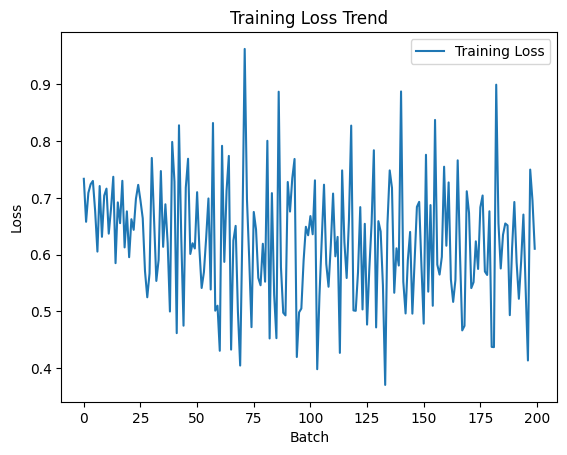

Accuracy: 60.53%
F1 Score: 0.46


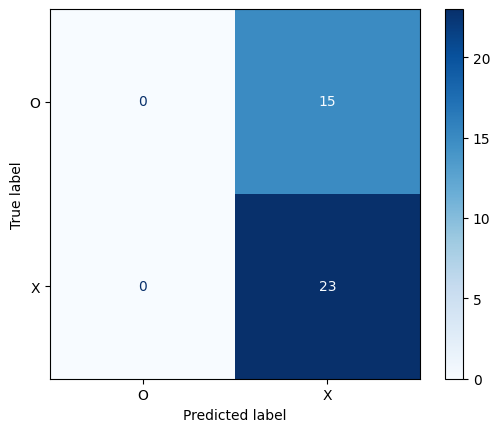

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Define the Adaptive Max Pooling Model
class AdaptiveMaxPoolingModel(LightningModule):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)

        # Adaptive Max Pooling layer
        self.adaptive_pool = nn.AdaptiveMaxPool2d(output_size=(4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(8 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.6)  # Increased dropout rate

        # Loss storage for visualization
        self.training_losses = []

    def forward(self, x):
        if isinstance(x, list):
            # Process list of tensors independently
            outputs = []
            for img in x:
                img = img.unsqueeze(0)  # Add batch dimension
                img = F.relu(self.conv1(img))
                img = F.relu(self.conv2(img))
                img = self.adaptive_pool(img)
                img = torch.flatten(img, start_dim=1)
                img = F.relu(self.fc1(img))
                img = self.dropout(img)
                img = self.fc2(img)
                outputs.append(img)
            return torch.cat(outputs, dim=0)  # Combine outputs into a batch
        else:
            # Standard forward pass for batched tensors
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.adaptive_pool(x)
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        predictions = self(images)
        loss = nn.CrossEntropyLoss()(predictions, labels)
        self.log("train_loss", loss)
        self.training_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        # AdamW optimizer with L2 regularization (weight decay)
        optimizer = AdamW(self.parameters(), lr=0.0005, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

# Helper functions for evaluation
def evaluate_model(model, dataloader):
    model.eval()  # Switch to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    return all_labels, all_predictions

def evaluate_confusion_matrix(all_labels, all_predictions):
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "X"])
    disp.plot(cmap="Blues")
    plt.show()

# Train the Model
model = AdaptiveMaxPoolingModel()
trainer = Trainer(max_epochs=50, log_every_n_steps=5)

# Fit the model on the training data
trainer.fit(model, train_dataloader)

# Plot the loss trend
plt.plot(range(len(model.training_losses)), model.training_losses, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss Trend")
plt.legend()
plt.show()

# Evaluate the model on the testing set
all_labels, all_predictions = evaluate_model(model, combined_dataloader)
evaluate_confusion_matrix(all_labels, all_predictions)


In [9]:
# Output dimensions of incorrectly classified examples
def output_incorrect_dimensions(model, dataloader):
    model.eval()  # Ensure model is in evaluation mode
    incorrect_dimensions = []

    with torch.no_grad():
        for images, labels in dataloader:
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Find indices of incorrect predictions
            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            # Record the dimensions of the incorrectly classified images
            for idx in incorrect_indices:
                image = images[idx]
                incorrect_dimensions.append(image.shape)

    # Print results
    print("Incorrectly Classified Image Dimensions:")
    for dim in incorrect_dimensions:
        print(dim)

# Call the function after the confusion matrix
output_incorrect_dimensions(model, combined_dataloader)


Incorrectly Classified Image Dimensions:
torch.Size([1, 32, 27])
torch.Size([1, 24, 24])
torch.Size([1, 9, 9])
torch.Size([1, 31, 30])
torch.Size([1, 23, 14])
torch.Size([1, 12, 12])
torch.Size([1, 26, 9])
torch.Size([1, 18, 18])
torch.Size([1, 12, 12])
torch.Size([1, 31, 13])
torch.Size([1, 7, 8])
torch.Size([1, 32, 21])
torch.Size([1, 6, 27])
torch.Size([1, 7, 19])
torch.Size([1, 28, 15])
